In [37]:
import os
import sys
import pandas as pd
import numpy as np
import requests
import itertools
import math
import configparser
from scipy.io import loadmat
import skimage
import requests
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color

config = configparser.ConfigParser()
config.read('../../config.ini')

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import visualize

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

colors = preprocessing.basic_colors()

In [3]:
def gauss(x, mu=0.0, sigma=1.0):
    """
    Return the value of the Gaussian probability function with mean mu
    and standard deviation sigma at the given x value.
    """
    # aus https://introcs.cs.princeton.edu/python/22module/gaussian.py.html
    x = float(x - mu) / sigma
    return math.exp(-x*x/2.0) / math.sqrt(2.0*math.pi) / sigma


In [6]:
def lab_to_rgb(lab):
    l,a,b = lab
    lab = LabColor(l,a,b)
    rgb = convert_color(lab, sRGBColor).get_value_tuple()
    rgb = tuple(c*255 for c in rgb)
    #print (rgb)
    rgb = tuple(c if c <= 255 else 255. for c in rgb)    
    return rgb

######################################
# Chip-basiertes Datenset LAB -> RGB #
######################################

# Textdatei abrufen
r = requests.get('http://www.cvc.uab.es/color_naming/MembershipValues_CIELab.txt')
# Text einlesen
data = r.text
# Zeilen trennen
data = data.split('\r\n')
# letzte Zeile ist leer
data = data[:-1]

# DataFrame erstellen mit Columns aus Text-Datei
# vgl. http://www.cvc.uab.es/color_naming/
columns = 'l a b red orange brown yellow green blue purple pink white gray black'.split()
columns_reordered = 'l a b'.split() + preprocessing.basic_colors()
df_lab = pd.DataFrame(columns=columns)

# Zeile für Zeile zu DataFrame hinzufügen
for line in data:
    s = pd.Series(line.split('\t'), index = columns)
    df_lab = df_lab.append(s,ignore_index=True)

# Type der Einträge von str zu float64
df_lab = df_lab.astype('float64')

df_rgb_converted = pd.DataFrame.from_records(
    list(df_lab.apply(lambda x: lab_to_rgb((x.l, x.a, x.b)), axis=1))
                         , columns='r g b'.split())
df_lab_rgb = pd.merge(df_rgb_converted, df_lab.drop('l a b'.split(),axis=1), left_index=True, right_index=True)

df = df_lab_rgb

# geordnete Liste mit RGB-Bins initialisieren
l = []
n = 3.5
for i in range(32):
    l.append(n)
    n += 8
rgb_bins = list(itertools.product(l,l,l))
rgb_bins = sorted(rgb_bins, key = lambda x: (x[2], x[1], x[0]))

chip_w2c = np.empty((0, 14))
# über RGB-Bins iterieren
for rgb_i in rgb_bins:
    # über RGB-Werte und Wahrscheinlichkeitsverteilungen (Chips) iterieren

    # np-Array für Wahrscheinlichkeitsverteilung über Farbnamen initialisieren
    p_i = np.zeros(11)

    for j in df.to_numpy():
        # j-Array: RGB-Werte von Wahrscheinlichkeitswerten trennen
        rgb_j = j[:3]
        p_j = j[3:]
        # Euklidische Distanz zwischen RGB-Werten von i und j
        distance = np.linalg.norm(rgb_i-rgb_j)
        p_j = p_j * gauss(distance, sigma=5)
        #p_j = p_j / len(df.to_numpy())
        p_i += p_j
    p_i = p_i / p_i.sum()
    i = np.append(rgb_i, p_i)
    chip_w2c = np.append(chip_w2c,[i], axis=0)

chip_w2c_df = pd.DataFrame(chip_w2c, columns=columns)
chip_w2c_df = chip_w2c_df[columns_reordered]

# als np-Array exportieren
chip_w2c_lab_arr = chip_w2c_df.to_numpy()

In [ ]:
#######################################
# Datensets als np-Arrays exportieren #
#######################################

loaded = np.load(vg_json_export+'w2c_data.npz')
w2c_arr = loaded['w2c']
chip_w2c_arr = loaded['chip_w2c']

np.savez_compressed(vg_json_export+'w2c_data.npz',
    w2c = w2c_arr,
    chip_w2c = chip_w2c_arr,
    chip_w2c_lab = chip_w2c_lab_arr
    )

loaded = np.load(vg_json_export+'w2c_data.npz')

print ('w2c-Array:', loaded['w2c'].shape)
print ('chip-based w2c-Array:', loaded['chip_w2c'].shape)
print ('Lab-chip-based w2c-Array:', loaded['chip_w2c_lab'].shape)

In [171]:
import pandas as pd
import numpy as np
import sys
import os
import configparser
import skimage

def color_pixelwise(img, w2c, bb=False):
    # vgl. Datei im2c.m aus http://lear.inrialpes.fr/people/vandeweijer/code/ColorNaming.tar
    # Input: Bild-Pfad und w2c-Matrix (Mapping von RGB-Werten zu Farbnamen)

    # Bild als Array
    img = skimage.io.imread(img)

    # für Grayscale-Bilder
    if len(img.shape) < 3:
        img = skimage.color.gray2rgb(img, alpha=None)

    # img-Array slicen, falls Bounding Box gegeben
    if bb:
        if type(bb) == list:
            bb ={
                'h' : bb[0],
                'w' : bb[1],
                'x' : bb[2],
                'y' : bb[3]
            }
        img = img[bb['y']:bb['y']+bb['h'], bb['x']:bb['x']+bb['w']]

    # Kanäle trennen
    RR=img[:,:,0]
    GG=img[:,:,1]
    BB=img[:,:,2]

    # Index-Array erstellen: Ein Index-Wert pro Pixel
    index_img = np.array(
        # R-Werte (32 Bins)
        np.floor(RR/8)+
        # G-Werte (32 Bins)
        32* np.floor(GG/8)+
        # B-Werte (32 Bins)
        32*32*np.floor(BB/8)
    )
    # Array für Wahrscheinlichkeitsverteilung über Farbklassen initialisieren
    clr_distribution = np.zeros(11)

    # Für jeden Index-Wert die jeweils assoziierte Wahrscheinlichkeitsverteilung zu clr_distribution addieren
    for pxl_index in index_img.ravel():
        clr_distribution = clr_distribution + w2c[int(pxl_index)][3:]

    # clr_distribution normalisieren
    clr_distribution = clr_distribution / len(index_img.ravel())

    return clr_distribution

def rows_pixelwise_classification(row,  w2c):
    bb = {
        'h' : row.bb_h,
        'w' : row.bb_w,
        'x' : row.bb_x,
        'y' : row.bb_y
    }
    img_path = image_dir + str(row.image_id) + '.jpg'
    return (np.append(row.Index, color_pixelwise(img_path, w2c, bb)))

--------------
## Minimale und maximale RGB-Werte

In [27]:
def lab_to_rgb(lab):
    l,a,b = lab
    lab = LabColor(l,a,b)
    rgb = convert_color(lab, sRGBColor).get_value_tuple()
    rgb = tuple(c*255 for c in rgb)
    #print (rgb)
    rgb = tuple(c if c <= 255 else 255. for c in rgb)    
    return rgb

######################################
# Chip-basiertes Datenset LAB -> RGB #
######################################

# Textdatei abrufen
r = requests.get('http://www.cvc.uab.es/color_naming/MembershipValues_CIELab.txt')
# Text einlesen
data = r.text
# Zeilen trennen
data = data.split('\r\n')
# letzte Zeile ist leer
data = data[:-1]

# DataFrame erstellen mit Columns aus Text-Datei
# vgl. http://www.cvc.uab.es/color_naming/
columns = 'l a b red orange brown yellow green blue purple pink white gray black'.split()
columns_reordered = 'l a b'.split() + preprocessing.basic_colors()
df_lab = pd.DataFrame(columns=columns)

# Zeile für Zeile zu DataFrame hinzufügen
for line in data:
    s = pd.Series(line.split('\t'), index = columns)
    df_lab = df_lab.append(s,ignore_index=True)

# Type der Einträge von str zu float64
df_lab = df_lab.astype('float64')

df_rgb_converted = pd.DataFrame.from_records(
    list(df_lab.apply(lambda x: lab_to_rgb((x.l, x.a, x.b)), axis=1))
                         , columns='r g b'.split())
df_lab_rgb = pd.merge(df_rgb_converted, df_lab.drop('l a b'.split(),axis=1), left_index=True, right_index=True)

In [5]:
# Textdatei abrufen
r = requests.get('http://www.cvc.uab.es/color_naming/MembershipValues_sRGB.txt')
# Text einlesen
data = r.text
# Zeilen trennen
data = data.split('\r\n')
# letzte Zeile ist leer
data = data[:-1]

# DataFrame erstellen mit Columns aus Text-Datei
# vgl. http://www.cvc.uab.es/color_naming/
columns = 'r g b red orange brown yellow green blue purple pink white gray black'.split()
columns_reordered = 'r g b'.split() + preprocessing.basic_colors()
df_rgb = pd.DataFrame(columns=columns)

# Zeile für Zeile zu DataFrame hinzufügen
for line in data:
    s = pd.Series(line.split('\t'), index = columns)
    df_rgb = df_rgb.append(s,ignore_index=True)

# Type der Einträge von str zu float64
df_rgb = df_rgb.astype('float64')

In [35]:
df_lab_rgb['color'] = df_lab_rgb[colors].idxmax(axis=1)
df_lab_rgb['rgb'] = df_lab_rgb.apply(lambda x: (round(x.r),round(x.g),round(x.b)), axis=1)

In [36]:
df_lab_rgb[['rgb', 'color']]

rgb   color
0      (161, 73, 87)     red
1      (200, 79, 92)     red
2     (215, 82, 113)    pink
3    (224, 118, 135)    pink
4    (228, 173, 171)    pink
5    (232, 201, 198)    pink
6    (231, 227, 224)    gray
7      (162, 79, 73)   brown
8      (200, 80, 79)     red
9     (217, 105, 93)     red
10   (218, 122, 127)    pink
11   (229, 172, 165)    pink
12   (232, 201, 194)    pink
13   (231, 227, 222)    gray
14     (160, 80, 68)   brown
15     (200, 84, 71)     red
16     (216, 90, 75)     red
17    (223, 128, 94)  orange
18   (227, 168, 153)    pink
19   (237, 199, 187)    pink
20   (237, 228, 223)   brown
21     (161, 69, 68)   brown
22     (191, 81, 69)     red
23    (213, 115, 61)  orange
24    (221, 127, 94)  orange
25    (221, 136, 76)  orange
26   (229, 184, 143)  orange
27   (232, 194, 176)    pink
28   (233, 222, 216)   brown
29     (140, 81, 63)   brown
..               ...     ...
357  (154, 159, 171)    gray
358  (149, 154, 166)    gray
359  (145, 151, 163)    gray
360  (139, 144, 155)    gray
361  (135, 139, 150)    gray
362  (130, 136, 146)    gray
363  (123, 129, 141)    gray
364  (117, 124, 136)    gray
365  (112, 120, 130)    gray
366  (107, 115, 126)    gray
367   (99, 106, 117)    gray
368    (91, 99, 107)    gray
369     (82, 89, 96)   black
370     (76, 83, 89)   black
371     (73, 78, 83)   black
372     (68, 72, 76)   black
373     (66, 68, 73)   black
374    (209, 69, 66)     red
375    (209, 69, 67)     red
376   (218, 120, 77)  orange
377    (211, 72, 80)     red
378    (213, 71, 81)     red
379    (204, 70, 79)     red
380  (218, 101, 103)     red
381    (209, 76, 62)     red
382    (210, 76, 64)     red
383    (205, 63, 57)     red
384    (206, 64, 56)     red
385    (199, 63, 60)     red
386    (215, 92, 64)     red

[387 rows x 2 columns]

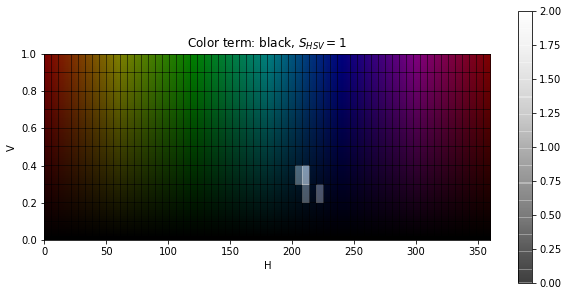

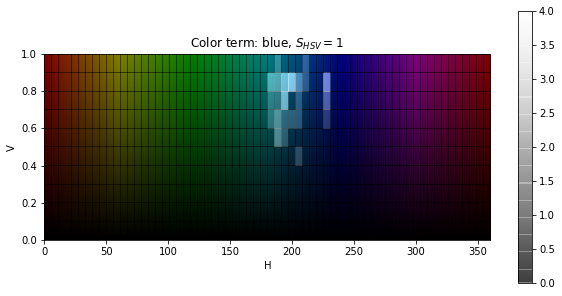

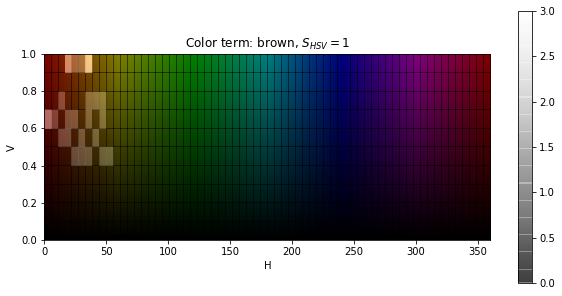

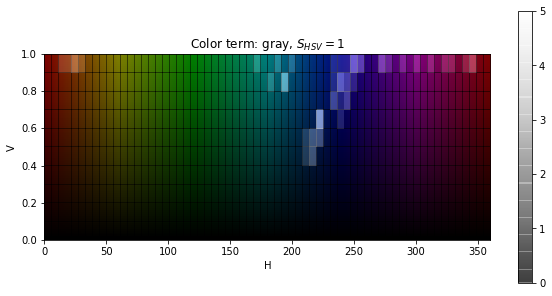

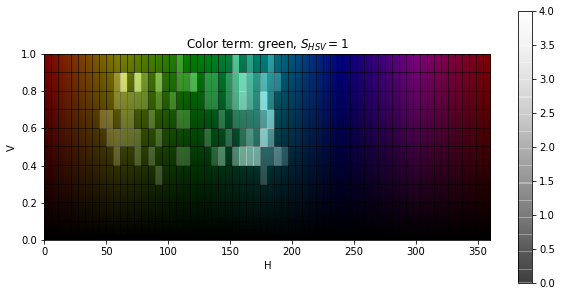

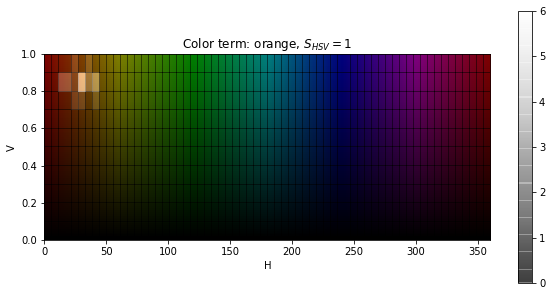

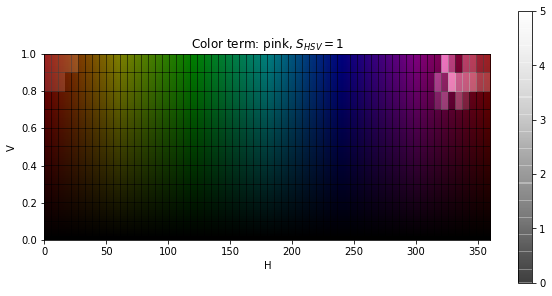

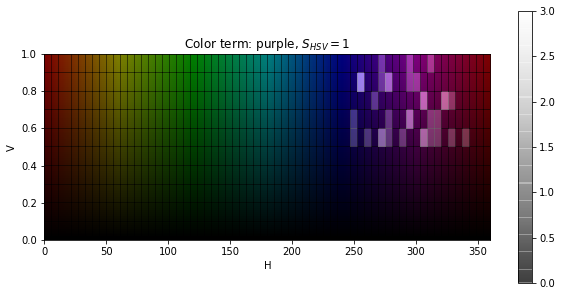

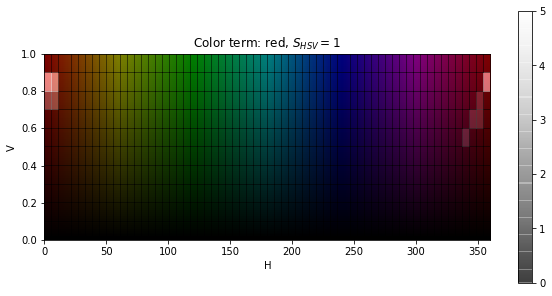

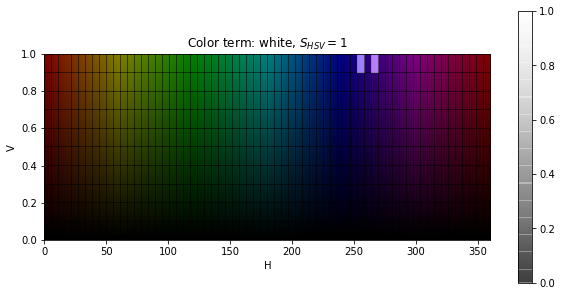

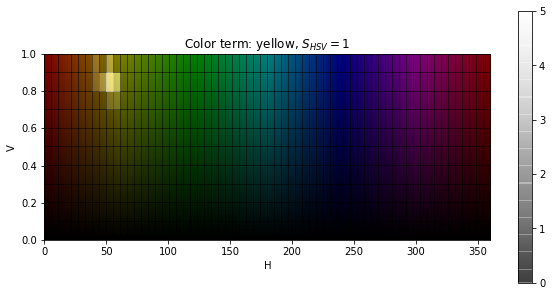

In [41]:
for color in colors:
    visualize.plot_in_hsv_chart(
        rgb_token=df_lab_rgb.loc[df_lab_rgb['color'] == color].rgb.values, 
        color_term=color, alpha=0.5, cmap='Greys_r',xbins=64,ybins=10,figsize=(10,5))